In [1]:
import pandas as pd
import numpy as np
import geopandas
import shapely.geometry as geom
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Read Macrozones Metadata

In [2]:
ctba_macrozones_data = pd.read_csv('/local/tarciso/data/pesquisa-od-ctba/shapefiles/ctba_macrozones_data.csv')

In [3]:
ctba_macrozones_data

,cod_macrozone,name,area_km2,population,pop_density,pop_proportion
0,1.0,Matriz,35.93,208674,5807.792931,0.110176
1,2.0,Portão,24.37,184437,7568.198605,0.097380
2,3.0,Cajuru,35.76,232563,6503.439597,0.122789
3,4.0,Santa Felicidade,62.22,166525,2676.390228,0.087922
4,5.0,Boa Vista,62.51,268556,4296.208607,0.141793
5,6.0,Boqueirão,39.81,205248,5155.689525,0.108367
6,7.0,Pinheirinho,24.71,151202,6119.061109,0.079832
7,8.0,CIC,63.46,200271,3155.861960,0.105740
8,9.0,Bairro Novo,45.01,163651,3635.880915,0.086405
9,10.0,Tatuquara,41.03,112873,2750.987083,0.059595


## BUSTE Baseline - Destinations inferred from Macrozones Population Proportion

## Start from origin zone-matched data

### Bus-Station matched Origins (BUSTE result)

#### Reading and Preparing Origin zone-matched data

In [4]:
trips_origins_zones = pd.read_csv('/local/tarciso/data/buste/BUSTE_zones_all.csv',parse_dates=['start_time'])

/home/tarciso/anaconda2/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
len(trips_origins_zones)

5493679

In [6]:
trips_origins_zones.dtypes

card_num                  int64
route                    object
start_time       datetime64[ns]
from_stop_id              int64
from_stop_lat           float64
from_stop_lon           float64
cod_zona_o                int64
cod_macroz_o            float64
municipio_o              object
densidade_o               int64
dtype: object

In [7]:
trips_origins_zones.head()

,card_num,route,start_time,from_stop_id,from_stop_lat,from_stop_lon,cod_zona_o,cod_macroz_o,municipio_o,densidade_o
0,840541,463,2017-04-30 05:49:19,31707,-25.478025,-49.203033,494,3.0,CURITIBA,10892
1,3545809,463,2017-04-30 05:57:45,30929,-25.443967,-49.237920,351,1.0,CURITIBA,2838
2,2351881,463,2017-04-30 06:45:52,31532,-25.476831,-49.192415,494,3.0,CURITIBA,10892
3,2114350,463,2017-04-30 06:45:44,31532,-25.476831,-49.192415,494,3.0,CURITIBA,10892
4,1698948,463,2017-04-30 06:45:40,31532,-25.476831,-49.192415,494,3.0,CURITIBA,10892


In [8]:
trips_origins_zones[pd.isnull(trips_origins_zones['cod_zona_o'])]

,card_num,route,start_time,from_stop_id,from_stop_lat,from_stop_lon,cod_zona_o,cod_macroz_o,municipio_o,densidade_o


### Aggregate Trips per Macrozone

In [9]:
trips_origins_per_macrozone = trips_origins_zones.groupby('cod_macroz_o').card_num.count().reset_index() \
                                            .rename(index=str, columns={'card_num':'macroz_total_boardings'})

In [10]:
trips_origins_per_macrozone

,cod_macroz_o,macroz_total_boardings
0,1.0,1409279
1,2.0,391638
2,3.0,433591
3,4.0,528272
4,5.0,742349
5,6.0,400285
6,7.0,337604
7,8.0,670761
8,9.0,257232
9,10.0,288418


# Inferring Aggregated Destination Macrozones based on Origin Population Density 

In [11]:
macrozones_pop_proportion = ctba_macrozones_data.rename(index=str, columns={'cod_macrozone':'cod_macroz_d'})

In [12]:
macrozones_pop_proportion

,cod_macroz_d,name,area_km2,population,pop_density,pop_proportion
0,1.0,Matriz,35.93,208674,5807.792931,0.110176
1,2.0,Portão,24.37,184437,7568.198605,0.097380
2,3.0,Cajuru,35.76,232563,6503.439597,0.122789
3,4.0,Santa Felicidade,62.22,166525,2676.390228,0.087922
4,5.0,Boa Vista,62.51,268556,4296.208607,0.141793
5,6.0,Boqueirão,39.81,205248,5155.689525,0.108367
6,7.0,Pinheirinho,24.71,151202,6119.061109,0.079832
7,8.0,CIC,63.46,200271,3155.861960,0.105740
8,9.0,Bairro Novo,45.01,163651,3635.880915,0.086405
9,10.0,Tatuquara,41.03,112873,2750.987083,0.059595


In [13]:
trips_od_macrozones_pop_prop = trips_origins_per_macrozone.assign(key=1).merge(macrozones_pop_proportion.assign(key=1), how='outer') \
                                        .filter(['cod_macroz_o','cod_macroz_d','macroz_total_boardings','pop_proportion']) \
                                        .assign(num_trips = lambda x: np.rint(x.macroz_total_boardings*x.pop_proportion))

In [14]:
trips_od_macrozones_pop_prop

,cod_macroz_o,cod_macroz_d,macroz_total_boardings,pop_proportion,num_trips
0,1.0,1.0,1409279,0.110176,155269.0
1,1.0,2.0,1409279,0.097380,137235.0
2,1.0,3.0,1409279,0.122789,173044.0
3,1.0,4.0,1409279,0.087922,123907.0
4,1.0,5.0,1409279,0.141793,199826.0
5,1.0,6.0,1409279,0.108367,152720.0
6,1.0,7.0,1409279,0.079832,112506.0
7,1.0,8.0,1409279,0.105740,149017.0
8,1.0,9.0,1409279,0.086405,121769.0
9,1.0,10.0,1409279,0.059595,83986.0


In [15]:
buste_baseline_pop_prop = trips_od_macrozones_pop_prop.filter(['cod_macroz_o','cod_macroz_d','num_trips'])

In [16]:
buste_baseline_pop_prop

,cod_macroz_o,cod_macroz_d,num_trips
0,1.0,1.0,155269.0
1,1.0,2.0,137235.0
2,1.0,3.0,173044.0
3,1.0,4.0,123907.0
4,1.0,5.0,199826.0
5,1.0,6.0,152720.0
6,1.0,7.0,112506.0
7,1.0,8.0,149017.0
8,1.0,9.0,121769.0
9,1.0,10.0,83986.0


## Generating Estimated Trips OD Matrix for Macrozones

In [17]:
buste_baseline_pop_prop_freqs = buste_baseline_pop_prop.pivot(index='cod_macroz_o',columns='cod_macroz_d',values='num_trips')

In [18]:
buste_baseline_pop_prop_freqs

cod_macroz_d,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
cod_macroz_o,,,,,,,,,,
1.0,155269.0,137235.0,173044.0,123907.0,199826.0,152720.0,112506.0,149017.0,121769.0,83986.0
2.0,43149.0,38138.0,48089.0,34434.0,55532.0,42441.0,31265.0,41412.0,33839.0,23340.0
3.0,47771.0,42223.0,53240.0,38122.0,61480.0,46987.0,34614.0,45848.0,37464.0,25840.0
4.0,58203.0,51443.0,64866.0,46447.0,74905.0,57248.0,42173.0,55859.0,45645.0,31482.0
5.0,81789.0,72290.0,91153.0,65269.0,105260.0,80446.0,59263.0,78496.0,64143.0,44240.0
6.0,44102.0,38980.0,49151.0,35194.0,56758.0,43378.0,31956.0,42326.0,34587.0,23855.0
7.0,37196.0,32876.0,41454.0,29683.0,47870.0,36585.0,26952.0,35698.0,29171.0,20120.0
8.0,73902.0,65318.0,82362.0,58975.0,95109.0,72689.0,53548.0,70926.0,57957.0,39974.0
9.0,28341.0,25049.0,31585.0,22616.0,36474.0,27876.0,20535.0,27200.0,22226.0,15330.0


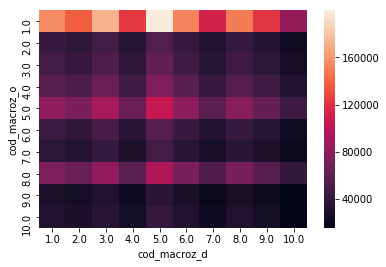

In [19]:
sns.heatmap(buste_baseline_pop_prop_freqs)

In [20]:
buste_baseline_pop_prop_norm_freqs = buste_baseline_pop_prop_freqs/buste_baseline_pop_prop_freqs.values.sum()

In [21]:
buste_baseline_pop_prop_norm_freqs

cod_macroz_d,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
cod_macroz_o,,,,,,,,,,
1.0,0.028441,0.025137,0.031696,0.022696,0.036602,0.027974,0.020608,0.027295,0.022304,0.015384
2.0,0.007904,0.006986,0.008808,0.006307,0.010172,0.007774,0.005727,0.007585,0.006198,0.004275
3.0,0.008750,0.007734,0.009752,0.006983,0.011261,0.008607,0.006340,0.008398,0.006862,0.004733
4.0,0.010661,0.009423,0.011881,0.008508,0.013720,0.010486,0.007725,0.010232,0.008361,0.005767
5.0,0.014981,0.013241,0.016696,0.011955,0.019280,0.014735,0.010855,0.014378,0.011749,0.008103
6.0,0.008078,0.007140,0.009003,0.006446,0.010396,0.007946,0.005853,0.007753,0.006335,0.004370
7.0,0.006813,0.006022,0.007593,0.005437,0.008768,0.006701,0.004937,0.006539,0.005343,0.003685
8.0,0.013537,0.011964,0.015086,0.010802,0.017421,0.013314,0.009808,0.012991,0.010616,0.007322
9.0,0.005191,0.004588,0.005785,0.004143,0.006681,0.005106,0.003761,0.004982,0.004071,0.002808


In [22]:
np.around(buste_baseline_pop_prop_norm_freqs,3)

cod_macroz_d,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
cod_macroz_o,,,,,,,,,,
1.0,0.028,0.025,0.032,0.023,0.037,0.028,0.021,0.027,0.022,0.015
2.0,0.008,0.007,0.009,0.006,0.010,0.008,0.006,0.008,0.006,0.004
3.0,0.009,0.008,0.010,0.007,0.011,0.009,0.006,0.008,0.007,0.005
4.0,0.011,0.009,0.012,0.009,0.014,0.010,0.008,0.010,0.008,0.006
5.0,0.015,0.013,0.017,0.012,0.019,0.015,0.011,0.014,0.012,0.008
6.0,0.008,0.007,0.009,0.006,0.010,0.008,0.006,0.008,0.006,0.004
7.0,0.007,0.006,0.008,0.005,0.009,0.007,0.005,0.007,0.005,0.004
8.0,0.014,0.012,0.015,0.011,0.017,0.013,0.010,0.013,0.011,0.007
9.0,0.005,0.005,0.006,0.004,0.007,0.005,0.004,0.005,0.004,0.003


In [23]:
buste_baseline_pop_prop_norm_freqs.to_csv('/local/tarciso/data/od-mat-validation/od-matrices/pop_prop_buste_baseline_norm_freqs.csv')

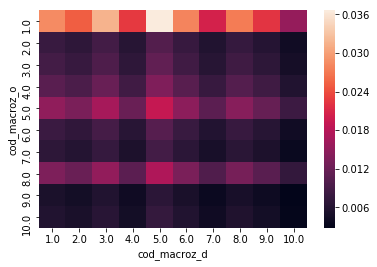

In [24]:
sns.heatmap(buste_baseline_pop_prop_norm_freqs)

# Inferring Aggregated Destination Macrozones based on Origin Population Density 

In [25]:
trips_origins_per_macrozone

,cod_macroz_o,macroz_total_boardings
0,1.0,1409279
1,2.0,391638
2,3.0,433591
3,4.0,528272
4,5.0,742349
5,6.0,400285
6,7.0,337604
7,8.0,670761
8,9.0,257232
9,10.0,288418


In [26]:
macrozones_origin_prop = trips_origins_per_macrozone.assign(origins_prop = lambda x: x.macroz_total_boardings/sum(x.macroz_total_boardings)) \
                                                .drop('macroz_total_boardings',axis=1) \
                                                .rename(index=str, columns={'cod_macroz_o':'cod_macroz_d'})

In [27]:
macrozones_origin_prop

,cod_macroz_d,origins_prop
0,1.0,0.258137
1,2.0,0.071736
2,3.0,0.079421
3,4.0,0.096763
4,5.0,0.135976
5,6.0,0.073320
6,7.0,0.061839
7,8.0,0.122863
8,9.0,0.047117
9,10.0,0.052829


In [28]:
trips_od_macrozones_origin_prop = trips_origins_per_macrozone.assign(key=1).merge(macrozones_origin_prop.assign(key=1), how='outer') \
                                        .filter(['cod_macroz_o','cod_macroz_d','macroz_total_boardings','origins_prop']) \
                                        .assign(num_trips = lambda x: np.rint(x.macroz_total_boardings*x.origins_prop))

In [29]:
trips_od_macrozones_origin_prop

,cod_macroz_o,cod_macroz_d,macroz_total_boardings,origins_prop,num_trips
0,1.0,1.0,1409279,0.258137,363787.0
1,1.0,2.0,1409279,0.071736,101096.0
2,1.0,3.0,1409279,0.079421,111926.0
3,1.0,4.0,1409279,0.096763,136366.0
4,1.0,5.0,1409279,0.135976,191628.0
5,1.0,6.0,1409279,0.073320,103328.0
6,1.0,7.0,1409279,0.061839,87148.0
7,1.0,8.0,1409279,0.122863,173148.0
8,1.0,9.0,1409279,0.047117,66401.0
9,1.0,10.0,1409279,0.052829,74451.0


In [30]:
buste_baseline_origin_prop = trips_od_macrozones_origin_prop.filter(['cod_macroz_o','cod_macroz_d','num_trips'])

In [31]:
buste_baseline_origin_prop

,cod_macroz_o,cod_macroz_d,num_trips
0,1.0,1.0,363787.0
1,1.0,2.0,101096.0
2,1.0,3.0,111926.0
3,1.0,4.0,136366.0
4,1.0,5.0,191628.0
5,1.0,6.0,103328.0
6,1.0,7.0,87148.0
7,1.0,8.0,173148.0
8,1.0,9.0,66401.0
9,1.0,10.0,74451.0


## Generating Estimated Trips OD Matrix for Macrozones

In [32]:
buste_baseline_origin_prop_freqs = buste_baseline_origin_prop.pivot(index='cod_macroz_o',columns='cod_macroz_d',values='num_trips')

In [33]:
buste_baseline_origin_prop_freqs

cod_macroz_d,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
cod_macroz_o,,,,,,,,,,
1.0,363787.0,101096.0,111926.0,136366.0,191628.0,103328.0,87148.0,173148.0,66401.0,74451.0
2.0,101096.0,28095.0,31104.0,37896.0,53253.0,28715.0,24218.0,48118.0,18453.0,20690.0
3.0,111926.0,31104.0,34436.0,41956.0,58958.0,31791.0,26813.0,53272.0,20430.0,22906.0
4.0,136366.0,37896.0,41956.0,51117.0,71832.0,38733.0,32668.0,64905.0,24891.0,27908.0
5.0,191628.0,53253.0,58958.0,71832.0,100941.0,54429.0,45906.0,91207.0,34977.0,39218.0
6.0,103328.0,28715.0,31791.0,38733.0,54429.0,29349.0,24753.0,49180.0,18860.0,21147.0
7.0,87148.0,24218.0,26813.0,32668.0,45906.0,24753.0,20877.0,41479.0,15907.0,17835.0
8.0,173148.0,48118.0,53272.0,64905.0,91207.0,49180.0,41479.0,82412.0,31604.0,35436.0
9.0,66401.0,18453.0,20430.0,24891.0,34977.0,18860.0,15907.0,31604.0,12120.0,13589.0


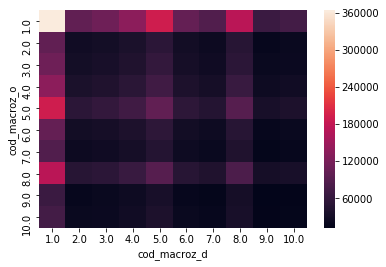

In [34]:
sns.heatmap(buste_baseline_origin_prop_freqs)

In [35]:
buste_baseline_origin_prop_norm_freqs = buste_baseline_origin_prop_freqs/buste_baseline_origin_prop_freqs.values.sum()

In [36]:
buste_baseline_origin_prop_norm_freqs

cod_macroz_d,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
cod_macroz_o,,,,,,,,,,
1.0,0.066635,0.018518,0.020501,0.024978,0.035100,0.018927,0.015963,0.031715,0.012163,0.013637
2.0,0.018518,0.005146,0.005697,0.006941,0.009754,0.005260,0.004436,0.008814,0.003380,0.003790
3.0,0.020501,0.005697,0.006308,0.007685,0.010799,0.005823,0.004911,0.009758,0.003742,0.004196
4.0,0.024978,0.006941,0.007685,0.009363,0.013157,0.007095,0.005984,0.011889,0.004559,0.005112
5.0,0.035100,0.009754,0.010799,0.013157,0.018489,0.009970,0.008409,0.016706,0.006407,0.007184
6.0,0.018927,0.005260,0.005823,0.007095,0.009970,0.005376,0.004534,0.009008,0.003455,0.003873
7.0,0.015963,0.004436,0.004911,0.005984,0.008409,0.004534,0.003824,0.007598,0.002914,0.003267
8.0,0.031715,0.008814,0.009758,0.011889,0.016706,0.009008,0.007598,0.015095,0.005789,0.006491
9.0,0.012163,0.003380,0.003742,0.004559,0.006407,0.003455,0.002914,0.005789,0.002220,0.002489


In [37]:
np.around(buste_baseline_origin_prop_norm_freqs,3)

cod_macroz_d,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
cod_macroz_o,,,,,,,,,,
1.0,0.067,0.019,0.021,0.025,0.035,0.019,0.016,0.032,0.012,0.014
2.0,0.019,0.005,0.006,0.007,0.010,0.005,0.004,0.009,0.003,0.004
3.0,0.021,0.006,0.006,0.008,0.011,0.006,0.005,0.010,0.004,0.004
4.0,0.025,0.007,0.008,0.009,0.013,0.007,0.006,0.012,0.005,0.005
5.0,0.035,0.010,0.011,0.013,0.018,0.010,0.008,0.017,0.006,0.007
6.0,0.019,0.005,0.006,0.007,0.010,0.005,0.005,0.009,0.003,0.004
7.0,0.016,0.004,0.005,0.006,0.008,0.005,0.004,0.008,0.003,0.003
8.0,0.032,0.009,0.010,0.012,0.017,0.009,0.008,0.015,0.006,0.006
9.0,0.012,0.003,0.004,0.005,0.006,0.003,0.003,0.006,0.002,0.002


In [38]:
buste_baseline_origin_prop_norm_freqs.to_csv('/local/tarciso/data/od-mat-validation/od-matrices/origin_prop_buste_baseline_norm_freqs.csv')

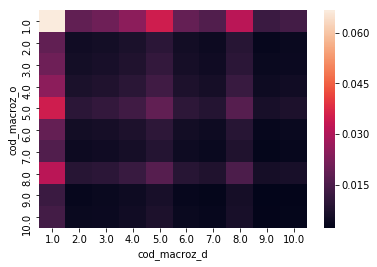

In [39]:
sns.heatmap(buste_baseline_origin_prop_norm_freqs)